### Load entities scraped from Wikipedia and NER

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import rdflib
import numpy as np
from random import shuffle

In [2]:
AS_entities = pd.read_csv('../entities/AnakinSkywalker_entities.csv').drop('Unnamed: 0', axis=1)
GL_entities = pd.read_csv('../entities/GeorgeLucas_entities.csv').drop('Unnamed: 0', axis=1)
J_entities = pd.read_csv('../entities/Jedi_entities.csv').drop('Unnamed: 0', axis=1)
MF_entities = pd.read_csv('../entities/MillenniumFalcon_entities.csv').drop('Unnamed: 0', axis=1)
SW_entities = pd.read_csv('../entities/StarWars_entities.csv').drop('Unnamed: 0', axis=1)
dataset = pd.concat([AS_entities, GL_entities, J_entities, MF_entities, SW_entities])
dataset

,Text,Start,End,Label
0,Darth Vader,0,11,PERSON
1,George Lucas,195,207,PERSON
2,first,241,246,ORDINAL
3,six,247,250,CARDINAL
4,Darth Vader,302,307,PERSON
...,...,...,...,...
871,October 2005,42070,42082,DATE
872,ISBN 978-0-7922,42084,42099,ORG
873,Star Wars on Wookieepedia,42148,42173,WORK_OF_ART
874,Star Wars wiki,42177,42191,WORK_OF_ART


In [3]:
entities = dataset['Text'].to_list()
print(len(entities))

4419


### Load entities from existing KB

In [4]:
graph = rdflib.Graph()
graph.parse('../data/starwars-data.ttl', format='turtle')

<Graph identifier=N024248a7ad9841609dafdca9a80e0df2 (<class 'rdflib.graph.Graph'>)>

In [5]:
query_str = """
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX voc: <https://swapi.co/vocabulary/>
    PREFIX xml: <http://www.w3.org/XML/1998/namespace>
    PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>


    SELECT ?o
    WHERE {   
        ?s rdfs:label ?o.
        FILTER (langMatches(lang(?o),"en"))
    }
"""
res = graph.query(query_str)
len(list(res))

1082

In [6]:
list(res)[:5]

[(rdflib.term.Literal('Chengdu', lang='en-GB')),
 (rdflib.term.Literal('Pittsburgh', lang='en')),
 (rdflib.term.Literal('Julian Glover', lang='en')),
 (rdflib.term.Literal('Barnes', lang='en')),
 (rdflib.term.Literal('France', lang='en-GB'))]

In [7]:
kb_entities = []
for o in list(res):
    kb_entities.append(str(o[0]))
kb_entities[:5]

['Chengdu', 'Pittsburgh', 'Julian Glover', 'Barnes', 'France']

In [8]:
entities[:5]

['Darth Vader', 'George Lucas', 'first', 'six', 'Darth Vader']

In [9]:
entities = list(set(kb_entities + entities))
len(entities)

2214

In [10]:
for index, entity in enumerate(entities):
    entities[index] = entity.replace(" ", "_")
len(entities)

2214

In [11]:
kb_entities = list(set(kb_entities))
len(kb_entities)

611

In [12]:
characters = pd.read_csv('../data/kaggle/characters.csv')
planets = pd.read_csv('../data/kaggle/planets.csv')
species = pd.read_csv('../data/kaggle/species.csv')
starships = pd.read_csv('../data/kaggle/starships.csv')
vehicles = pd.read_csv('../data/kaggle/vehicles.csv')
characters.head()

,name,height,mass,hair_color,skin_color,eye_color,birth_year,gender,homeworld,species
0,Luke Skywalker,172.0,77,blond,fair,blue,19BBY,male,Tatooine,Human
1,C-3PO,167.0,75,NaN,gold,yellow,112BBY,NaN,Tatooine,Droid
2,R2-D2,96.0,32,NaN,"white, blue",red,33BBY,NaN,Naboo,Droid
3,Darth Vader,202.0,136,none,white,yellow,41.9BBY,male,Tatooine,Human
4,Leia Organa,150.0,49,brown,light,brown,19BBY,female,Alderaan,Human


In [13]:
entities = pd.concat([characters['name'], planets['name'], species['name'], starships['name'], vehicles['name']]).tolist()

vocabulary = []
for index, entity in enumerate(entities):
    words = str(entity).split(' ')
    for word in words:
        vocabulary.append(word.lower())
    
shuffle(vocabulary)
print(vocabulary[:5])
len(vocabulary)

['bike', 'jet', 'offee', 'barge', 'gregar']


439

### Load Pre-trained Word Vectors

In [14]:
%%time
embeddings = {}
file = open('../../../glove.6B/glove.6B.50d.txt', encoding='utf-8')

for line in file:
    fields = line.strip().split(" ")
    word = fields[0]
    embeddings[word] = [float(x) for x in fields[1:]]

len(embeddings)

CPU times: user 5.49 s, sys: 351 ms, total: 5.84 s
Wall time: 5.91 s


400000

In [15]:
len(embeddings.keys())

400000

In [16]:
len(embeddings['organa'])

50

In [17]:
word_vector_matrix = np.zeros((len(vocabulary), 50))

count = 0
for index, word in enumerate(vocabulary):
    vector = embeddings.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector
    else:
        count += 1
print('words not in embed: ' + str(count))
word_vector_matrix.shape
word_vector_matrix

words not in embed: 168


array([[-0.066264,  0.63021 ,  0.29176 , ..., -1.4157  ,  0.71565 ,
        -0.087735],
       [ 1.295   , -0.11407 ,  0.96883 , ...,  0.10743 , -0.27815 ,
         0.10925 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [ 0.23272 ,  0.59108 , -1.1557  , ..., -1.088   , -0.27955 ,
        -0.78883 ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [-0.18548 , -0.45376 , -0.82937 , ..., -0.81792 , -0.024871,
        -0.7107  ]])

### Unsupervised Concept Extraction: Kmeans Clustering

In [18]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,3)).fit(entities)
x_vec = tfidf_vec.transform(entities)
x_vec.shape

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [19]:
num_of_clusters = 10
sum_of_squared_dist = []
for k in range(1, num_of_clusters):
    model = KMeans(n_clusters=k, init='k-means++', n_init=100)
    model.fit(word_vector_matrix)
    sum_of_squared_dist.append(model.inertia_)

Text(0, 0.5, 'SSD')

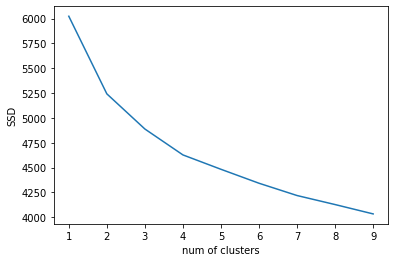

In [20]:
plt.plot(range(1,num_of_clusters), sum_of_squared_dist)
plt.xlabel('num of clusters')
plt.ylabel('SSD')

In [23]:
model = KMeans(n_clusters=4, init='k-means++', n_init=100)
model.fit(word_vector_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=100, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [28]:
labels = model.labels_
centroids = model.cluster_centers_
print(len(labels), len(centroids))

439 4


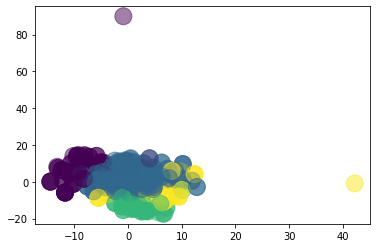

In [31]:
import matplotlib.pyplot as plt
 
from sklearn.manifold import TSNE
 
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model.fit_transform(word_vector_matrix)
plt.scatter(Y[:, 0], Y[:, 1], c=labels, s=290,alpha=.5)
plt.show()

In [21]:
from sklearn.cluster import AffinityPropagation
import distance

In [22]:
words = np.array(entities[0:100])
len(words)
print(words[:10])

['Luke Skywalker' 'C-3PO' 'R2-D2' 'Darth Vader' 'Leia Organa' 'Owen Lars'
 'Beru Whitesun lars' 'R5-D4' 'Biggs Darklighter' 'Obi-Wan Kenobi']


In [217]:
lev_similarity = -1*np.array([[distance.levenshtein(w1,w2) for w1 in words] for w2 in words])

In [218]:
affprop = AffinityPropagation(affinity="precomputed", damping=0.5)
affprop.fit(lev_similarity)
for cluster_id in np.unique(affprop.labels_):
    exemplar = words[affprop.cluster_centers_indices_[cluster_id]]
    cluster = np.unique(words[np.nonzero(affprop.labels_==cluster_id)])
    cluster_str = ", ".join(cluster)
    print("*%s*: %s" % (exemplar, cluster_str))

*Tsmeu-6_personal_wheel_bike*: Tsmeu-6_personal_wheel_bike
*Muun*: AT-ST, AT-TE, Finn, Human, Hutt, Mustafar, Muun, Muunilinst, Nautolan, Pau'an, R4-P17, Yoda, arc-170
*Bantha-II_cargo_skiff*: Bantha-II_cargo_skiff, Naboo_star_skiff
*Jedi_Interceptor*: Jedi_Interceptor, TIE/IN_interceptor
*Sentinel-class_landing_craft*: Sentinel-class_landing_craft
*Trade_Federation_cruiser*: Trade_Federation_cruiser
*Geonosian_starfighter*: Geonosian_starfighter
*Kamino*: A-wing, Aleen_Minor, Ben_Quadinaros, Clawdite, Dagobah, Dantooine, Eeth_Koth, Gasgano, Kaleesh, Kamino, Kaminoan, Kit_Fisto, Mace_Windu, Naboo, Plo_Koon, Ryloth, Saesee_Tiin, Shili, Tatooine
*Neimoidian_shuttle*: Neimoidian_shuttle
*J-type_diplomatic_barge*: J-type_diplomatic_barge
*C-9979_landing_craft*: C-9979_landing_craft
*Multi-Troop_Transport*: Multi-Troop_Transport
*Oevvaor_jet_catamaran*: Oevvaor_jet_catamaran
*Wilhuff_Tarkin*: Vulture_Droid, Wilhuff_Tarkin
*Sith_speeder*: Flitknot_speeder, Ratts_Tyerell, Sith_speeder, Snowsp